In [1]:
%load_ext autoreload
%autoreload 2

from datasets import DataCocoFeat
from models import LSTMCaption
from optimers import OptimerAdam, OptimerSGD
from utils import check_gradient, show_training_info

import numpy as np

In [2]:
# load data
dataloader = DataCocoFeat('./datasets/coco_captioning/', pca_features=False)
dataloader.show_info()

Training data shape:  (400135, 4096)
Training labels shape:  (400135, 17)
Validation data shape:  (195954, 4096)
Validation labels shape:  (195954, 17)
Number of training images:  82783
Number of validation images:  40504
Number of words:  1004


In [3]:
def get_init_model(hyperparams, device=''):
    return LSTMCaption(dataloader.x_train.shape[1], None, hyperparams=hyperparams, seed=101, device=device)


def test_model(model, data, idx_train, idx_val):
    caps_train = model.predict(data.x_train[idx_train])
    caps_val = model.predict(data.x_val[idx_val])

    # the predicted captions
    for i in range(len(caps_train)):
        print('Predicted training data:', data.decode_captions(caps_train[i]))
        data.show_by_index(idx_train[i], data_type='train')

    for i in range(len(caps_val)):
        print('Predicted validation data:', data.decode_captions(caps_val[i]))
        data.show_by_index(idx_val[i], data_type='val')

# Sanity check

### Init loss

In [9]:
# init model
model = get_init_model({'word_to_idx': dataloader.data['word_to_idx'],
                        'reg': 0., 'num_hidden': 32, 'num_vector': 32, 'init_scale': None}, device='gpu')

# init loss
loss = model.backward(dataloader.x_train[0: 64, :], dataloader.y_train[0: 64])
print('Sanity check result:')
print('Init loss is', loss)

Sanity check result:
Init loss is 75.44866


### Gradient check

In [5]:
# gradient check
for i in range(1):
    print('\nGradient check result - ', i + 1, ':')
    check_gradient(model, dataloader.x_train[0: 100, :], dataloader.y_train[0: 100], h=0.1)


Gradient check result -  1 :
Layer | Key | Numerical gradient | Calculated gradient | Relative error
<class 'models.layers.layers.Linear'> W -0.00400543212890625 -0.0039922167 0.0033048381293079056
<class 'models.layers.layers.Linear'> b -0.0160980224609375 -0.016096309 0.00010645560685481538
<class 'models.layers.rnn_layers.WordEmbedding'> W_embed 0.00011444091796875 0.00012557466 0.09277517022362114
<class 'models.layers.rnn_layers.LSTM'> Wx -3.814697265625e-05 -1.5424397e-05 0.8483104169844242
<class 'models.layers.rnn_layers.LSTM'> Wh 0.020599365234375 0.020700786 0.004911411929454265
<class 'models.layers.rnn_layers.LSTM'> b -0.13309478759765625 -0.1341988 0.008260670543811775
<class 'models.layers.rnn_layers.LinearForRNN'> W 3.814697265625e-05 3.5659043e-05 0.06741808301733228
<class 'models.layers.rnn_layers.LinearForRNN'> b 0.01064300537109375 0.010606273 0.003457274443873068


### Overfit small dataset

In [13]:
# load small dataset
smallloader = DataCocoFeat('./datasets/coco_captioning/', pca_features=True,
                           num_train=64, num_val=64, order_by='random')

# init model
model = get_init_model({'word_to_idx': dataloader.data['word_to_idx'],
                        'reg': 0., 'num_hidden': 512, 'num_vector': 256}, device='gpu')

# train model
optimer = OptimerAdam({'learn_rate': 5e-3, 'learn_rate_decay': 0.995, 'num_iters': 200, 'batch_size': 32}, 
                      print_every=10, check_val_acc=False, check_train_acc=False)

optimer.train(model, smallloader)

# save model
model.save('./saves/LSTMCaption/model_small.pkl')

0 / 200 loss is 75.59723
10 / 200 loss is 57.595222
20 / 200 loss is 46.38684
30 / 200 loss is 36.521168
40 / 200 loss is 29.986237
50 / 200 loss is 22.501554
60 / 200 loss is 11.815059
70 / 200 loss is 8.599895
80 / 200 loss is 5.9375134
90 / 200 loss is 3.402547
100 / 200 loss is 2.1105094
110 / 200 loss is 1.7428353
120 / 200 loss is 0.9676044
130 / 200 loss is 0.6377594
140 / 200 loss is 0.6751859
150 / 200 loss is 0.41628247
160 / 200 loss is 0.34846687
170 / 200 loss is 0.2898669
180 / 200 loss is 0.26759142
190 / 200 loss is 0.19723411


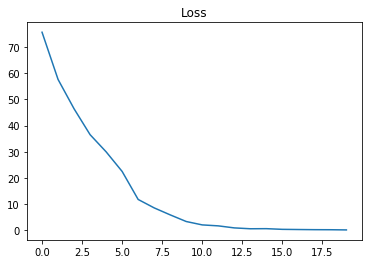

In [14]:
# plot loss curve
show_training_info(optimer)

Predicted training data: <START> a person <UNK> with a snowboard that is <UNK> <END>


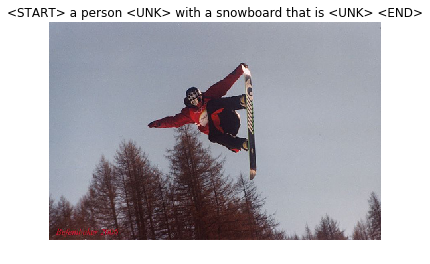

Predicted training data: <START> two <UNK> elephants look <UNK> toward their <UNK> <END>


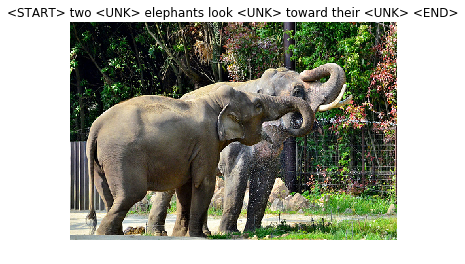

Predicted training data: <START> a sheep standing on top of a hay <UNK> <END>


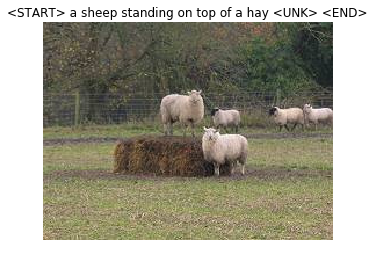

Predicted validation data: <START> woman in <UNK> riding gear on top of a horse <END>


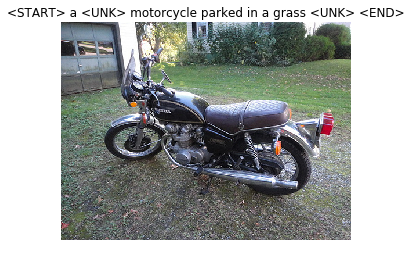

Predicted validation data: <START> woman in <UNK> riding gear on top of a horse <END>


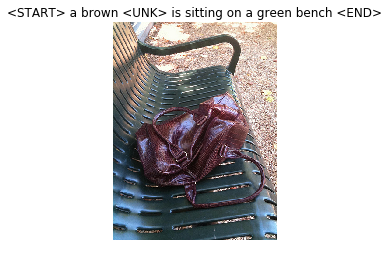

Predicted validation data: <START> a man and a child standing in the leaves near a bench <END>


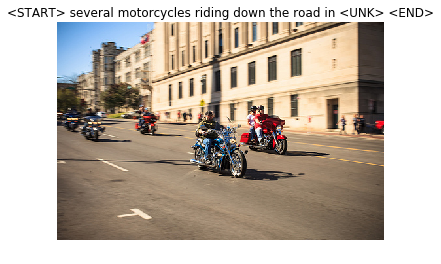

In [15]:
# load model
model = LSTMCaption.load('./saves/LSTMCaption/model_small.pkl')

# test model
test_model(model, smallloader, [0, 1, 3], [0, 1, 2])

# Run time test

### Backpropagation

In [10]:
# init model
hyperparam = {'word_to_idx': dataloader.data['word_to_idx'],
              'reg': 0., 'num_hidden': 1024, 'num_vector': 512, 'init_scale': None}

# init model
model1 = get_init_model(hyperparam, device='cpu')
model2 = get_init_model(hyperparam, device='gpu')

# the backpropagation
print('\nRun time for CPU model:')
loss1 = model1.backward(dataloader.x_train[0: 256, :], dataloader.y_train[0: 256], print_time=True)

print('\nRun time for GPU model:')
loss2 = model2.backward(dataloader.x_train[0: 256, :], dataloader.y_train[0: 256], print_time=True)


Run time for CPU model:
Forward time: 1.543121099472046
    Input linear forward time: 0.029475927352905273
    Word embedding forward time: 0.0047359466552734375
    RNN forward time: 1.4109406471252441
    Output linear forward time: 0.09796857833862305

Backward time: 1.9421732425689697
    Loss calculate time: 0.14427900314331055
    Output linear backward time: 0.08202648162841797
    RNN backward time: 1.54500150680542
    Word embedding backward time: 0.13335061073303223
    Input linear backward time: 0.03751564025878906

Reg time: 0.05644726753234863

Run time for GPU model:
Forward time: 0.06093168258666992
    Input linear forward time: 0.0025289058685302734
    Word embedding forward time: 0.0009059906005859375
    RNN forward time: 0.05447506904602051
    Output linear forward time: 0.003021717071533203

Backward time: 0.08460593223571777
    Loss calculate time: 0.00614619255065918
    Output linear backward time: 0.004804134368896484
    RNN backward time: 0.07038664817

### Parameters modification

In [12]:
# init optimer
optimer = OptimerAdam({'learn_rate': 2e-3, 'learn_rate_decay': 0.995, 'num_iters': 1, 'batch_size': 256}, 
                      print_every=None)

# parameter modify
print('\nRun time for CPU model:')
optimer.train(model1, dataloader, print_time=True)

print('\nRun time for GPU model:')
optimer.train(model2, dataloader, print_time=True)


Run time for CPU model:
Time: 3.746886968612671
    Load data: 0.011400461196899414
    Backpropagate: 3.3010122776031494
    Modify parameters: 0.4344661235809326
    Others: 8.106231689453125e-06

Run time for GPU model:
Time: 0.1270589828491211
    Load data: 0.011085987091064453
    Backpropagate: 0.11078882217407227
    Modify parameters: 0.005178213119506836
    Others: 5.9604644775390625e-06


# Train LSTM-Caption model

### Train Model

In [4]:
# init model
if False:
    model = get_init_model({'word_to_idx': dataloader.data['word_to_idx'],
                            'reg': 1e-3, 'num_hidden': 512, 'num_vector': 512}, device='gpu')
else:
    model = LSTMCaption.load('./saves/LSTMCaption/model.pkl')

# train model: Adam 'learn_rate': 2e-3
optimer = OptimerAdam({'learn_rate': 1e-5, 'learn_rate_decay': 0.95, 'num_iters': 10000, 'batch_size': 512}, 
                      print_every=100, check_val_acc=False, check_train_acc=False)

optimer.train(model, dataloader)

# save model
model.save('./saves/LSTMCaption/model.pkl')

0 / 10000 loss is 22.62277
100 / 10000 loss is 22.501942
200 / 10000 loss is 22.986195
300 / 10000 loss is 22.486122
400 / 10000 loss is 23.113325
500 / 10000 loss is 23.434196
600 / 10000 loss is 22.48366
700 / 10000 loss is 22.623278
800 / 10000 loss is 22.698404
900 / 10000 loss is 22.391611
1000 / 10000 loss is 22.922653
1100 / 10000 loss is 21.793417
1200 / 10000 loss is 22.747347
1300 / 10000 loss is 22.330597
1400 / 10000 loss is 22.268404
1500 / 10000 loss is 22.971092
1600 / 10000 loss is 22.695515
1700 / 10000 loss is 22.377453
1800 / 10000 loss is 22.037811
1900 / 10000 loss is 22.41396
2000 / 10000 loss is 22.578829
2100 / 10000 loss is 22.619139
2200 / 10000 loss is 23.40074
2300 / 10000 loss is 22.584898
2400 / 10000 loss is 21.955454
2500 / 10000 loss is 22.691147
2600 / 10000 loss is 22.579988
2700 / 10000 loss is 22.571472
2800 / 10000 loss is 22.503162
2900 / 10000 loss is 22.407013
3000 / 10000 loss is 22.227985
3100 / 10000 loss is 22.45683
3200 / 10000 loss is 22.5

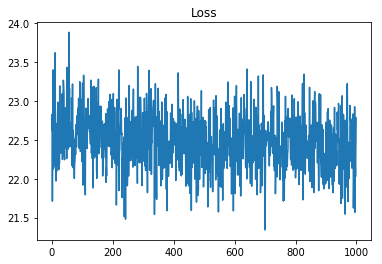

In [5]:
# plot loss curve
show_training_info(optimer)

Predicted training data: <START> a sign that is on a pole in the middle of a field <END>


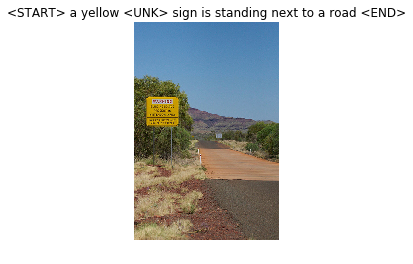

Predicted training data: <START> a woman is <UNK> her cell phone to her ear <END>


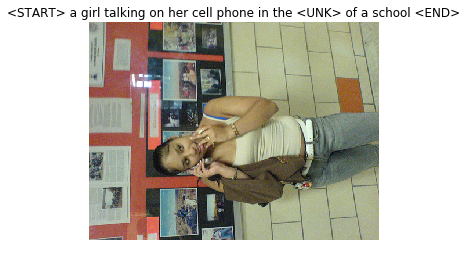

Predicted training data: <START> a group of people flying kites in a field <END>


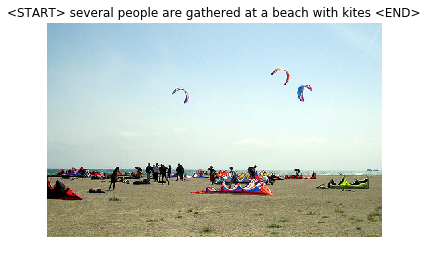

Predicted training data: <START> a white refrigerator with a <UNK> <UNK> on top of it <END>


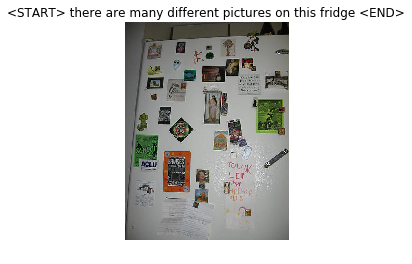

Predicted training data: <START> a man <UNK> a <UNK> to a <UNK> <END>


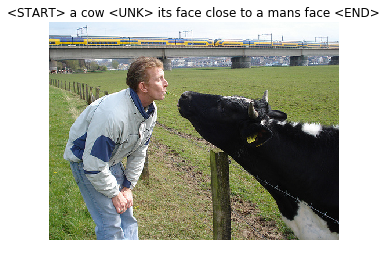

Predicted validation data: <START> a man standing on a tennis court holding a racquet <END>


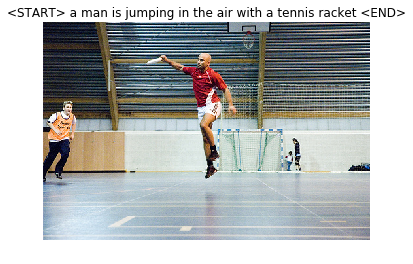

Predicted validation data: <START> a boat is on the water near a <UNK> <END>


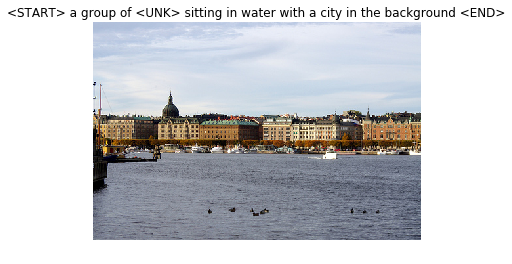

Predicted validation data: <START> a man sitting on a <UNK> <UNK> in front of a <UNK> <END>


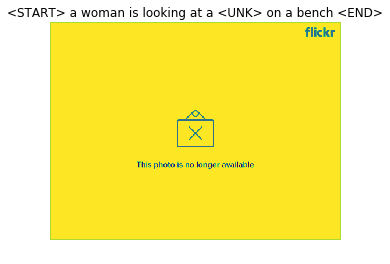

Predicted validation data: <START> a black and white photo of a train with people on it <END>


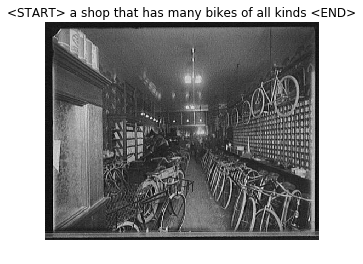

Predicted validation data: <START> a group of young people playing a game of frisbee <END>


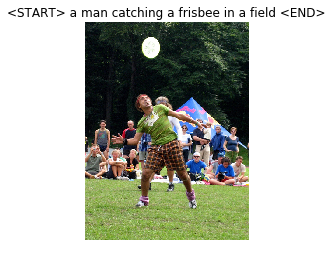

Predicted validation data: <START> a couple of cows that are standing in the grass <END>


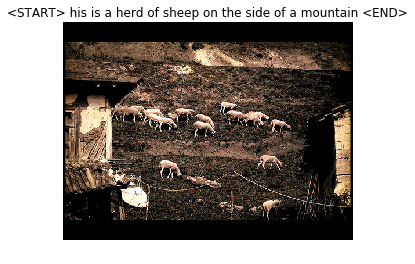

Predicted validation data: <START> a train is parked on the train tracks <END>


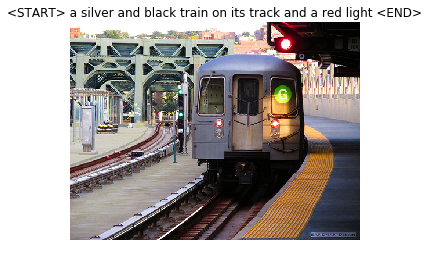

Predicted validation data: <START> a <UNK> <UNK> sign with a <UNK> <UNK> on it <END>


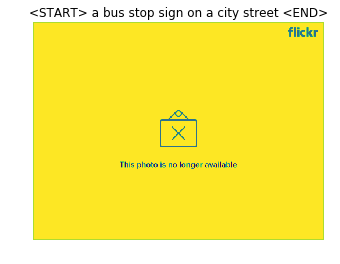

Predicted validation data: <START> a cat sitting on top of a car looking at the camera <END>


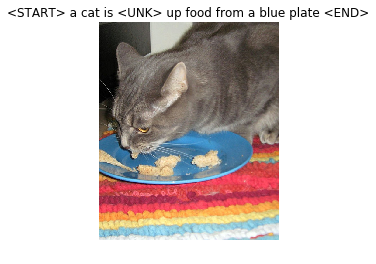

Predicted validation data: <START> a table with a plate of food and a glass of wine <END>


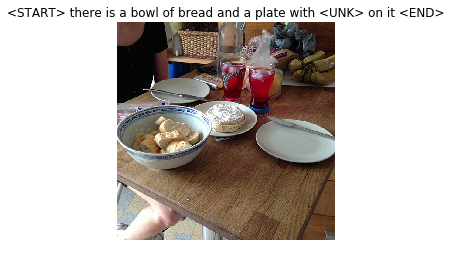

In [8]:
# load model
model = LSTMCaption.load('./saves/LSTMCaption/model.pkl')

# test model
np.random.seed(102)
train_idx = np.random.choice(dataloader.num_train, 5)
val_idx = np.random.choice(dataloader.num_val, 10)
test_model(model, dataloader, train_idx, val_idx)